In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
import cv2
from torchvision import transforms
from typing import Dict, List, Tuple, Optional
from torch.optim import Adam

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, cohen_kappa_score
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision.models import resnet18, ResNet18_Weights, resnet34, ResNet34_Weights

scan_directory = '/kaggle/input/all-mias/'

file_path = '/kaggle/input/Info.txt'

# PART I: Exploratory Data Analysis

In [47]:
column_names = [
    'Reference_Number', 'Background_Tissue', 'Abnormality_Class', 'Severity_Abnormality', 'X', 'Y', 'RADIUS' 
]
mias_df = pd.read_csv(file_path, sep=" ").drop('Unnamed: 7',axis=1)
mias_df.columns = column_names
mias_df

,Reference_Number,Background_Tissue,Abnormality_Class,Severity_Abnormality,X,Y,RADIUS
0,mdb001,G,CIRC,B,535.0,425.0,197.0
1,mdb002,G,CIRC,B,522.0,280.0,69.0
2,mdb003,D,NORM,NaN,NaN,NaN,NaN
3,mdb004,D,NORM,NaN,NaN,NaN,NaN
4,mdb005,F,CIRC,B,477.0,133.0,30.0
...,...,...,...,...,...,...,...
325,mdb318,D,NORM,NaN,NaN,NaN,NaN
326,mdb319,D,NORM,NaN,NaN,NaN,NaN
327,mdb320,D,NORM,NaN,NaN,NaN,NaN
328,mdb321,D,NORM,NaN,NaN,NaN,NaN


In [48]:
mias_df.describe()

,X,Y,RADIUS
count,119.000000,119.000000,119.000000
mean,488.605042,520.983193,48.848739
std,134.144131,178.828342,33.558863
min,127.000000,125.000000,3.000000
25%,398.500000,427.000000,27.000000
50%,505.000000,524.000000,41.000000
75%,574.500000,621.000000,61.500000
max,793.000000,994.000000,197.000000


In [49]:
mias_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Reference_Number      330 non-null    object 
 1   Background_Tissue     330 non-null    object 
 2   Abnormality_Class     330 non-null    object 
 3   Severity_Abnormality  123 non-null    object 
 4   X                     119 non-null    float64
 5   Y                     119 non-null    float64
 6   RADIUS                119 non-null    float64
dtypes: float64(3), object(4)
memory usage: 18.2+ KB


In [50]:
mias_df[mias_df['Abnormality_Class'] == 'NORM'].isna().sum()

Reference_Number          0
Background_Tissue         0
Abnormality_Class         0
Severity_Abnormality    207
X                       207
Y                       207
RADIUS                  207
dtype: int64

In [51]:
mias_df['Severity_Abnormality'] = mias_df['Severity_Abnormality'].fillna('N')
mias_df.drop_duplicates(subset='Reference_Number', inplace=True)
mias_df.set_index('Reference_Number', inplace=True)
mias_df

,Background_Tissue,Abnormality_Class,Severity_Abnormality,X,Y,RADIUS
Reference_Number,,,,,,
mdb001,G,CIRC,B,535.0,425.0,197.0
mdb002,G,CIRC,B,522.0,280.0,69.0
mdb003,D,NORM,N,NaN,NaN,NaN
mdb004,D,NORM,N,NaN,NaN,NaN
mdb005,F,CIRC,B,477.0,133.0,30.0
...,...,...,...,...,...,...
mdb318,D,NORM,N,NaN,NaN,NaN
mdb319,D,NORM,N,NaN,NaN,NaN
mdb320,D,NORM,N,NaN,NaN,NaN


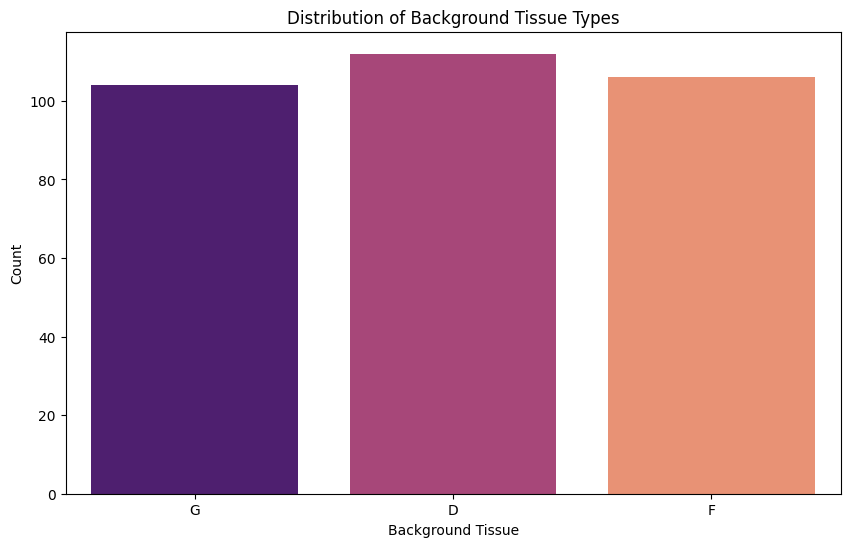

In [52]:
plt.figure(figsize=(10, 6))
sns.countplot(data=mias_df, x='Background_Tissue', palette="magma")
plt.title("Distribution of Background Tissue Types")
plt.xlabel("Background Tissue")
plt.ylabel("Count")
plt.show()

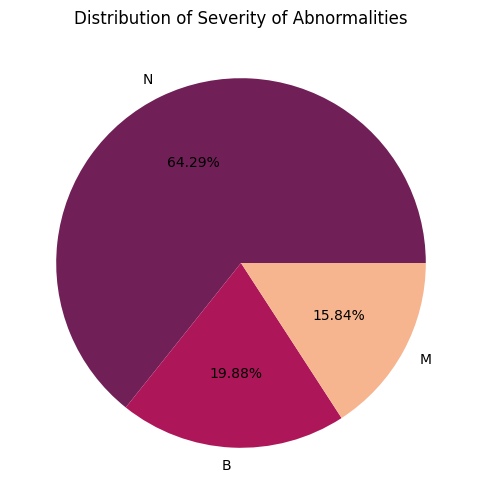

In [53]:
plt.figure(figsize=(10, 6))
mias_df['Severity_Abnormality'].value_counts().plot.pie(autopct='%.2f%%', colors=['#701f57','#ad1759','#f6b48f'])
plt.title("Distribution of Severity of Abnormalities")
plt.ylabel("")
plt.show()

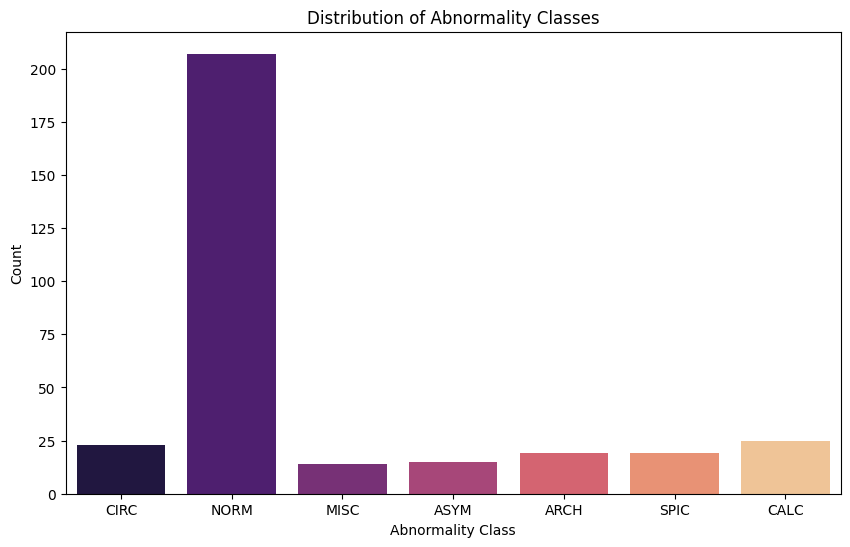

In [54]:
plt.figure(figsize=(10, 6))
sns.countplot(data=mias_df, x='Abnormality_Class', palette="magma")
plt.title("Distribution of Abnormality Classes")
plt.xlabel("Abnormality Class")
plt.ylabel("Count")
plt.show()

In [55]:
mias_df.groupby(['Abnormality_Class', 'Severity_Abnormality'])['Severity_Abnormality'].count().unstack()

Severity_Abnormality,B,M,N
Abnormality_Class,,,
ARCH,9.0,10.0,NaN
ASYM,6.0,9.0,NaN
CALC,12.0,13.0,NaN
CIRC,19.0,4.0,NaN
MISC,7.0,7.0,NaN
NORM,NaN,NaN,207.0
SPIC,11.0,8.0,NaN


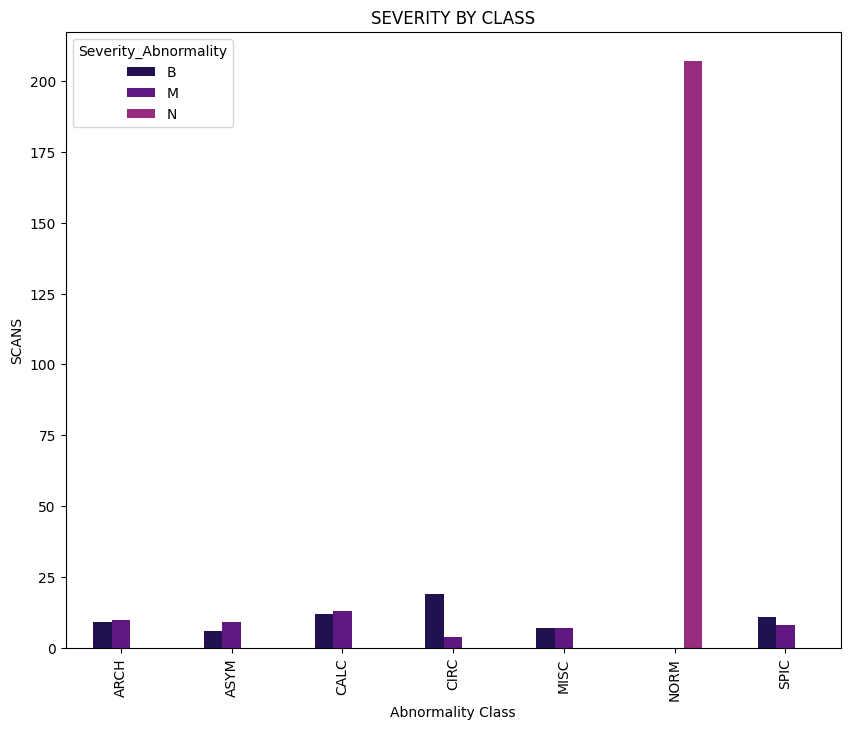

In [56]:
mias_df.groupby(['Abnormality_Class', 'Severity_Abnormality']).size().unstack().plot(kind='bar', 
                                                               figsize=(10, 8),
                                                               color=sns.color_palette("magma"),
                                                               xlabel='Abnormality Class', 
                                                               ylabel='SCANS',
                                                               title='SEVERITY BY CLASS');

In [57]:
scan_df = mias_df.copy()
scan_df['scan_path'] = scan_df.index.map(lambda x: os.path.join(scan_directory, f"{x}.pgm"))

scan_df.head()

,Background_Tissue,Abnormality_Class,Severity_Abnormality,X,Y,RADIUS,scan_path
Reference_Number,,,,,,,
mdb001,G,CIRC,B,535.0,425.0,197.0,/kaggle/input/all-mias/mdb001.pgm
mdb002,G,CIRC,B,522.0,280.0,69.0,/kaggle/input/all-mias/mdb002.pgm
mdb003,D,NORM,N,NaN,NaN,NaN,/kaggle/input/all-mias/mdb003.pgm
mdb004,D,NORM,N,NaN,NaN,NaN,/kaggle/input/all-mias/mdb004.pgm
mdb005,F,CIRC,B,477.0,133.0,30.0,/kaggle/input/all-mias/mdb005.pgm


In [58]:
def prepare_data(scan_df):
    """
    Prepare data for three classes: Normal, Benign, and Malignant
    """
    print("Original distribution of Classes:")
    print(scan_df['Severity_Abnormality'].value_counts())
    
    # Convert labels to numeric: Normal=0, Benign=1, Malignant=2
    label_map = {'N': 0, 'B': 1, 'M': 2}
    labels = scan_df['Severity_Abnormality'].map(label_map).values
    image_paths = scan_df['scan_path'].values
    
    print("\nClass Distribution after mapping:")
    print(pd.Series(labels).map({0: 'Normal', 1: 'Benign', 2: 'Malignant'}).value_counts())
    
    # Split data
    train_paths, test_paths, train_labels, test_labels = train_test_split(
        image_paths, labels, test_size=0.2, random_state=42, stratify=labels
    )
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        train_paths, train_labels, test_size=0.2, random_state=42, 
        stratify=train_labels
    )
    
    return (train_paths, val_paths, test_paths, 
            train_labels, val_labels, test_labels)

In [59]:
class MIASDataset(Dataset):
    def __init__(self, image_paths, labels, preprocessor, augmenter):
        self.image_paths = image_paths
        self.labels = labels
        self.preprocessor = preprocessor
        self.augmenter = augmenter
    
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)
        
        image = self.preprocessor.preprocess(image)
        
        # Apply augmentation if specified
        if self.augmenter is not None:
            image = self.augmenter.apply_augmentation(image)
        
        # Convert to tensor and add channel dimension
        image = torch.FloatTensor(image).unsqueeze(0)  # Shape: (1, H, W)
        
        return image, self.labels[idx]

In [60]:
class ScanPreprocessor:
    """
    
    """
    def __init__(self, target_size=(224, 224), gaussian_kernel=(5,5), clahe_clip=2.0, clahe_grid=(8, 8)):
        self.target_size = target = target_size
        self.gaussian_kernel = gaussian_kernel
        self.clahe_clip = clahe_clip
        self.clahe_grid = clahe_grid
        self.clahe = cv2.createCLAHE(clipLimit=clahe_clip, tileGridSize=clahe_grid)
    
    def resize_image(self, image):
        return cv2.resize(image, self.target_size)
    
    def gaussian_filter(self, image):
        return cv2.GaussianBlur(image, self.gaussian_kernel, 0)
    
    def clahe_filter(self, image):
        return self.clahe.apply(image)
    
    def otsu_threshold(self, image):
        _, mask = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        return cv2.bitwise_and(image, image, mask=mask)
    
    def normalize(self, image):
        return image / 255.0
    
    def preprocess(self, image):
        resized_image = self.resize_image(image)
        denoised_image = self.gaussian_filter(resized_image)
        contrast_image = self.clahe_filter(denoised_image)
        thresholded_image = self.otsu_threshold(contrast_image)
        normalized_image = self.normalize(thresholded_image)
        return normalized_image
    
    def visualize_preprocessing(self, scan_path):
        original_image = cv2.imread(scan_path, cv2.IMREAD_GRAYSCALE)
        resized_image = self.resize_image(original_image)
        denoised_image = self.gaussian_filter(resized_image)
        contrast_image = self.clahe_filter(denoised_image)
        thresholded_image = self.otsu_threshold(contrast_image)
        normalized_image = self.normalize(thresholded_image)
        
        # Plot
        fig, axes = plt.subplots(2,3, figsize=(10, 10))
        images = [original_image, resized_image, denoised_image, contrast_image, thresholded_image, normalized_image]
        titles = ['Original', 'Resized', 'Gaussian Blur', 
                 'CLAHE', 'Background Removed', 'Normalized']
        
        for ax, img, title in zip(axes.ravel(), images, titles):
            ax.imshow(img, cmap='gray')
            ax.set_title(title)
            ax.axis('off')
        
        plt.tight_layout()
        plt.show()

Original distribution of Classes:
Severity_Abnormality
N    207
B     64
M     51
Name: count, dtype: int64

Class Distribution after mapping:
Normal       207
Benign        64
Malignant     51
Name: count, dtype: int64


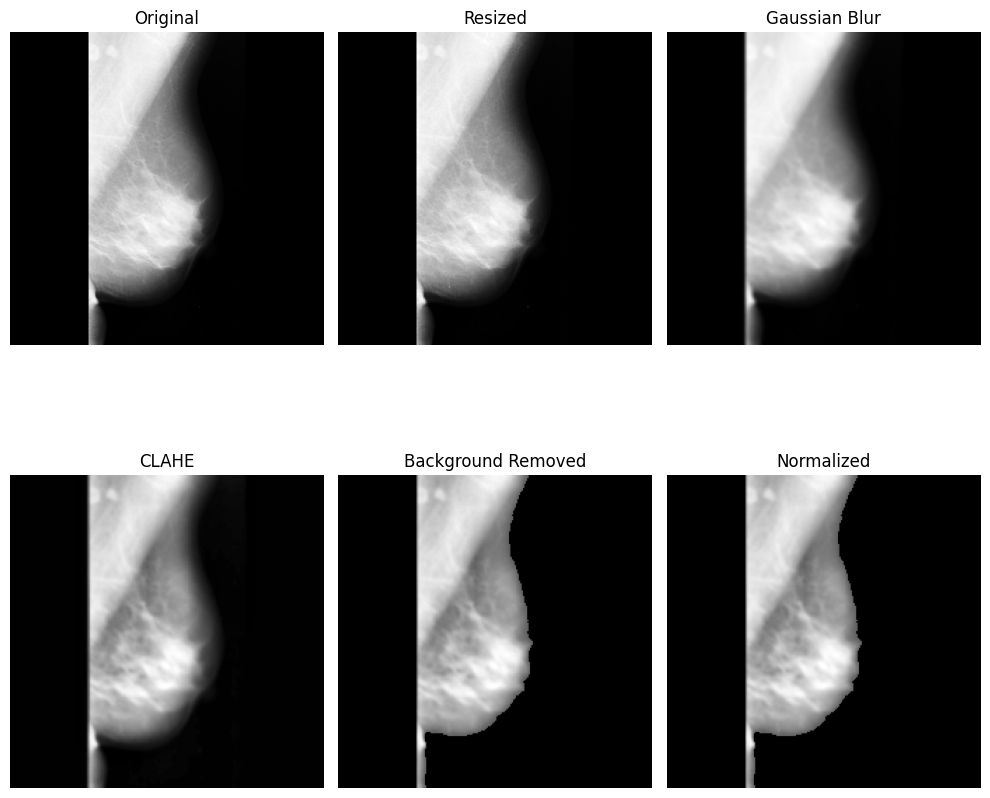

In [61]:
if __name__ == "__main__":
    
    preprocessor = ScanPreprocessor(
    target_size =(224, 224),
    gaussian_kernel=(5,5), 
    clahe_clip=2.0, 
    clahe_grid=(8, 8))
    
    # Prepare data
    train_paths, val_paths, test_paths, train_labels, val_labels, test_labels = prepare_data(scan_df)
    
    # Create datasets
    train_dataset = MIASDataset(train_paths, train_labels, preprocessor, augmenter=None)
    val_dataset = MIASDataset(val_paths, val_labels, preprocessor, augmenter=None)
    test_dataset = MIASDataset(test_paths, test_labels, preprocessor, augmenter=None)
    
    sample_image_path = train_paths[0]
    preprocessor.visualize_preprocessing(sample_image_path)

In [62]:
class DataAugmentation:
    def __init__(self):
        self.transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(15),  # 15 degrees
            transforms.RandomAffine(
                degrees=0,
                translate=(0.05, 0.05),  # 5% translation
                scale=(0.95, 1.05),      # 5% scaling
            ),
            transforms.ToTensor(),
        ])

    def apply_augmentation(self, image):
        """Apply augmentation to a single image"""
        if not isinstance(image, torch.Tensor):
            image = transforms.ToTensor()(image)
        image = transforms.ToPILImage()(image)
        return self.transforms(image)

    def visualize_augmentations(self, preprocessed_image, num_samples=5):
        """Visualize multiple augmentations of the same image"""
        fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
        
        for i in range(num_samples):
            # Original
            axes[0, i].imshow(preprocessed_image, cmap='gray')
            axes[0, i].set_title('Original')
            axes[0, i].axis('off')
            
            # Augmented
            augmented = self.apply_augmentation(preprocessed_image)
            axes[1, i].imshow(augmented.squeeze(), cmap='gray')
            axes[1, i].set_title(f'Augmented {i+1}')
            axes[1, i].axis('off')
        
        plt.tight_layout()
        plt.show()

Original distribution of Classes:
Severity_Abnormality
N    207
B     64
M     51
Name: count, dtype: int64

Class Distribution after mapping:
Normal       207
Benign        64
Malignant     51
Name: count, dtype: int64

Visualizing augmentations...


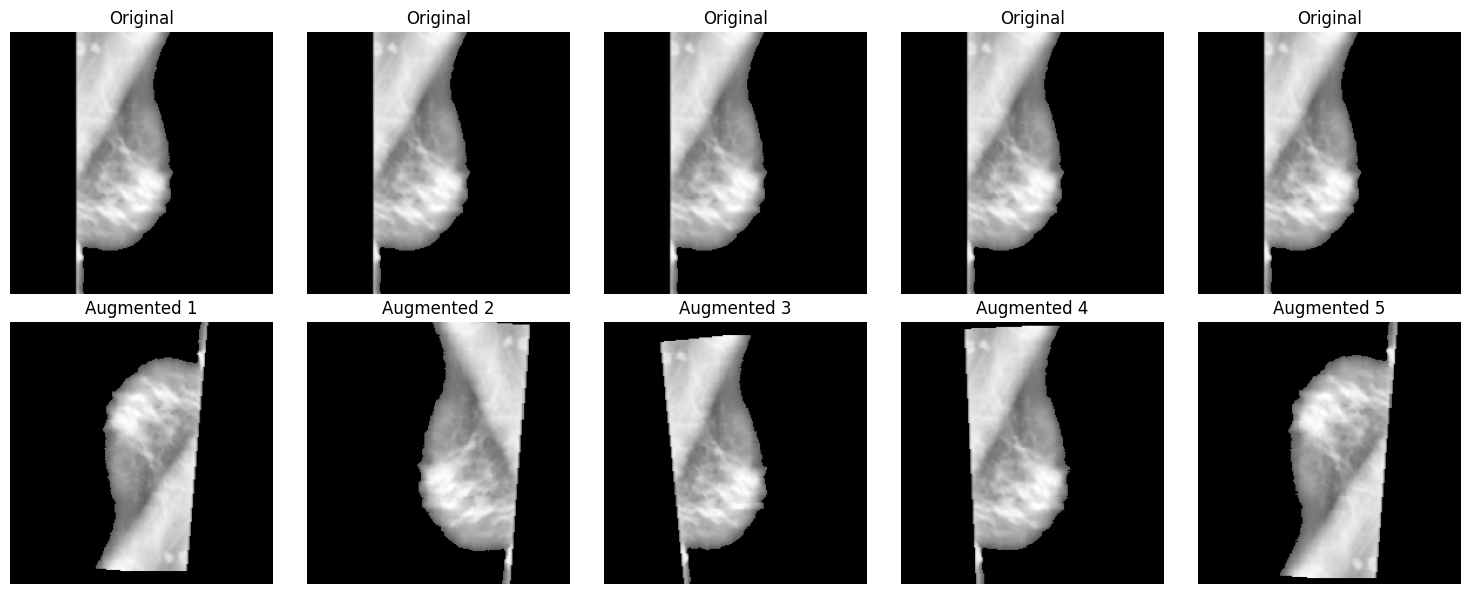

In [67]:
if __name__ == "__main__":
    
    augmenter = DataAugmentation()
    
    preprocessor = ScanPreprocessor(
    target_size =(224, 224),
    gaussian_kernel=(5,5), 
    clahe_clip=2.0, 
    clahe_grid=(8, 8))
    
    # Prepare data
    train_paths, val_paths, test_paths, train_labels, val_labels, test_labels = prepare_data(scan_df)
    
    # Create datasets
    train_dataset = MIASDataset(train_paths, train_labels, preprocessor, augmenter)
    val_dataset = MIASDataset(val_paths, val_labels, preprocessor, augmenter=None)
    test_dataset = MIASDataset(test_paths, test_labels, preprocessor, augmenter=None)
    
    sample_image_path = train_paths[0]
    print("\nVisualizing augmentations...")
    sample_image = cv2.imread(sample_image_path, cv2.IMREAD_GRAYSCALE)
    preprocessed_image = preprocessor.preprocess(sample_image)
    augmenter.visualize_augmentations(preprocessed_image)

In [68]:
def calculate_class_weights(labels):
    """
    Calculate weights for balanced sampling
    """
    class_counts = np.bincount(labels)
    total_samples = len(labels)
    
    # Calculate weights inversely proportional to class frequencies
    weights = total_samples / (len(class_counts) * class_counts)
    
    # Create sample weights
    sample_weights = weights[labels]
    
    return torch.FloatTensor(sample_weights)

In [97]:
class CNN(nn.Module):
    """
    Convolutional Neural Network architecture for image classification.
    
    The network consists of three convolutional blocks (each with Conv2D, ReLU, and MaxPool)
    followed by fully connected layers with dropout for regularization.
    """
    
    def __init__(self ,num_classes) -> None:
        super(CNN, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 26 * 26, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the network.
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, channels, height, width)
            
        Returns:
            torch.Tensor: Output tensor of shape (batch_size, num_classes)
        """
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x


class ResNet18(nn.Module):
    """
    ResNet18 modified for mammogram classification
    """
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()  # Add parent class initialization
        
        # Load pretrained ResNet18
        weights = ResNet18_Weights.DEFAULT
        self.model = resnet18(weights=weights)
        
        # Modify first layer for grayscale input
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Modify final classification layer
        num_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.model(x)

class ResNet34(nn.Module):
    """
    ResNet34 modified for mammogram classification
    """
    def __init__(self, num_classes):
        super(ResNet34, self).__init__()  # Add parent class initialization
        
        # Load pretrained ResNet34
        weights = ResNet34_Weights.DEFAULT
        self.model = resnet34(weights=weights)
        
        # Modify first layer for grayscale input
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Modify final classification layer
        num_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.model(x)

class DenseNet(nn.Module):
    """
    DenseNet121 modified for mammogram classification
    """
    def __init__(self, num_classes):
        super(DenseNet, self).__init__()  # Add parent class initialization
        
        # Load pretrained DenseNet121
        self.model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
        
        # Modify first layer for grayscale input
        self.model.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Modify final classification layer
        num_features = self.model.classifier.in_features
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        return self.model(x)


class ModelTrainer:
    """
    A trainer class for managing the training, evaluation, and visualization of neural networks.
    """
    
    def __init__(
        self,
        config: dict = None
    ) -> None:
        """
        Initialize the trainer with configuration dictionary.
        
        Args:
            config (dict): Configuration dictionary containing parameters
        """
        # Default configuration
        self.default_config = {
            # Model parameters
            'model': 'cnn',
            'num_classes':None,
            'class_names':None,
            'training_params': {
                'num_epochs': 10,
                'batch_size': 64,
                'learning_rate': 0.0001,
                'optimizer': 'adam',
                'criterion': 'cross_entropy',
            },
            'device': 'cuda' if torch.cuda.is_available() else 'cpu',
        }
        
        # Update default config with user config
        self.config = self.default_config.copy()
        if config:
            self.config.update(config)
        
        # Setup device
        self.device = torch.device(
            'cuda' if torch.cuda.is_available() and self.config['device'] == 'cuda' 
            else 'cpu'
        )
        print(f"Using device: {self.device}")
        
        num_classes=self.config['num_classes']
        
        # Initialize model
        if self.config['model'] == 'resnet18':
            self.model = ResNet18(num_classes)
        if self.config['model'] == 'resnet34':
            self.model = ResNet34(num_classes)
        elif self.config['model'] == 'cnn':
            self.model = CNN(num_classes)
        else:
            raise ValueError(f"Unsupported model type: {self.config['model']}")
            
        self.model = self.model.to(self.device)
        
        # Setup training parameters
        training_params = self.config['training_params']
        
        # Initialize criterion
        if training_params['criterion'] == 'cross_entropy':
            self.criterion = nn.CrossEntropyLoss()
        elif training_params['criterion'] == 'bce':
            self.criterion = nn.BCEWithLogitsLoss()
        
        # Initialize optimizer
        if training_params['optimizer'] == 'adam':
            self.optimizer = Adam(
                self.model.parameters(),
                lr=training_params['learning_rate']
            )

    def train(
        self,
        train_loader: torch.utils.data.DataLoader,
        val_loader: torch.utils.data.DataLoader,
    ) -> Dict[str, List[float]]:
        """
        Train the model using the configured parameters.
        """
        num_epochs = self.config['training_params']['num_epochs']
        best_val_acc = 0
        history = {
            'train_loss': [],
            'val_loss': [],
            'train_acc': [],
            'val_acc': []
        }
        
        for epoch in range(num_epochs):
            # Training phase
            self.model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            
           #for images, labels in train_loader:
           #     images, labels = images.to(self.device), labels.to(self.device)
            for i, (images, labels) in enumerate(train_loader):
                # Ensure correct shape
                if images.dim() > 4:
                    images = images.squeeze(1)  # Remove extra dimension if present

                # Move to device
                images, labels = images.to(self.device), labels.to(self.device) 
                
                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
            
            train_loss = running_loss / len(train_loader)
            train_acc = 100. * correct / total
            
            # Validation phase
            val_loss, val_acc = self._validate(val_loader)
            
            # Save history
            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)
            history['train_acc'].append(train_acc)
            history['val_acc'].append(val_acc)
            
            print(f'Epoch [{epoch+1}/{num_epochs}]')
            print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        
        return history

    def _validate(
        self,
        val_loader: torch.utils.data.DataLoader
    ) -> Tuple[float, float]:
        """
        Internal method to validate the model.
        
        Args:
            val_loader (DataLoader): DataLoader for validation data
            
        Returns:
            tuple: (validation_loss, validation_accuracy)
        """
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        val_loss = running_loss / len(val_loader)
        val_acc = 100. * correct / total
        
        return val_loss, val_acc

    def evaluate(
        self,
        test_loader: torch.utils.data.DataLoader
    ) -> None:
        """
        Evaluate the model on test data and display results.
        
        Args:
            test_loader (DataLoader): DataLoader for test data
        """
        self.model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                _, predicted = outputs.max(1)
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        # Cohen Kappa Score
        print("\nCohen Kappa Score:")
        print(cohen_kappa_score(all_labels, all_preds))
        
        class_names = list(self.config['class_names'])
        # Generate classification report and confusion matrix
        print("\nClassification Report:")
        print(classification_report(all_labels, all_preds, target_names=class_names))
        
        print("\nConfusion Matrix:")
        cm = confusion_matrix(all_labels, all_preds)
        ConfusionMatrixDisplay(cm).plot()

    def plot_results(self, history: Dict[str, List[float]]) -> None:
        """
        Plot training and validation metrics history.
        
        Args:
            history (dict): Dictionary containing training history
        """
        plt.figure(figsize=(12, 4))
        
        # Plot loss
        plt.subplot(1, 2, 1)
        plt.plot(history['train_loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Val Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        # Plot accuracy
        plt.subplot(1, 2, 2)
        plt.plot(history['train_acc'], label='Train Acc')
        plt.plot(history['val_acc'], label='Val Acc')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

In [91]:
class MammogramDataModule:
    def __init__(self, 
                 scan_df,
                 preprocessor,
                 augmenter,
                 batch_size=32):
        """
        Args:
            scan_df: DataFrame containing image paths and labels
            preprocessor: Image preprocessing object
            augmenter: Data augmentation object (optional)
            batch_size: Batch size for DataLoader
        """
        self.scan_df = scan_df
        self.preprocessor = preprocessor
        self.augmenter = augmenter
        self.batch_size = batch_size
        
        # Initialize datasets
        self.train_dataset = None
        self.val_dataset = None
        self.test_dataset = None
        
        # Initialize data loaders
        self.train_loader = None
        self.val_loader = None
        self.test_loader = None
        
    def setup(self):
        """Prepare the data"""
        # Split the data
        (train_paths, val_paths, test_paths,
         train_labels, val_labels, test_labels) = prepare_data(self.scan_df)
        
        sample_weights = calculate_class_weights(train_labels)
        
        # Create datasets
        self.train_dataset = MIASDataset(
            train_paths, train_labels, 
            self.preprocessor, 
            self.augmenter
        )
        
        # Create weighted sampler
        self.train_sampler = WeightedRandomSampler(
            weights=sample_weights,
            num_samples=len(train_labels),
            replacement=True
        )
        
        self.val_dataset = MIASDataset(
            val_paths, val_labels, 
            self.preprocessor,
            augmenter=None
        )
        
        self.test_dataset = MIASDataset(
            test_paths, test_labels, 
            self.preprocessor,
            augmenter=None
        )
        
        # Create data loaders
        self.train_loader = DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            sampler = self.train_sampler
        )
        
        self.val_loader = DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False
        )
        
        self.test_loader = DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False
        )
        
        print(f"Data setup completed:")
        print(f"Training samples: {len(self.train_dataset)}")
        print(f"Validation samples: {len(self.val_dataset)}")
        print(f"Test samples: {len(self.test_dataset)}")
        
        # Visualize data distribution
        self.plot_data_distribution()
        
    def get_loaders(self):
        """Return all data loaders"""
        return self.train_loader, self.val_loader, self.test_loader
    
    def plot_data_distribution(self):
        """Plot the distribution of classes in each split"""
        # Get labels for each split
        train_labels = [label.item() for _, label in self.train_dataset]
        val_labels = [label.item() for _, label in self.val_dataset]
        test_labels = [label.item() for _, label in self.test_dataset]
        
        # Create distribution dictionary
        distribution = {
        'Train': pd.Series(train_labels).map({0: 'Normal', 1: 'Benign', 2: 'Malignant'}).value_counts(),
        'Validation': pd.Series(val_labels).map({0: 'Normal', 1: 'Benign', 2: 'Malignant'}).value_counts(),
        'Test': pd.Series(test_labels).map({0: 'Normal', 1: 'Benign', 2: 'Malignant'}).value_counts()
        }
    
        # Plot
        plt.figure(figsize=(12, 6))
        df_dist = pd.DataFrame(distribution)
        
        ax = df_dist.plot(kind='bar', color=sns.color_palette("magma"))
        plt.title('Class Distribution Across Data Splits')
        plt.xlabel('Class')
        plt.ylabel('Number of Samples')
        plt.legend(title='Split')
        plt.xticks(rotation=45)
        
        # Add value labels on bars
        for container in ax.containers:
            ax.bar_label(container)
            
        plt.tight_layout()
        plt.show()

In [72]:
def main(model):
    """
    Main function that runs the complete mammogram classification pipeline
    
    Args:
        model (str): Type of model to use ('resnet18' or 'cnn')
    """
    # Configuration
    config = {
        # Model parameters
        'model': model,
        'num_classes': 2,
        'class_names': ['Normal', 'Benign', 'Malignant'],
        'training_params': {
            'num_epochs': 10,
            'batch_size': 32,
            'learning_rate': 0.0001,
            'optimizer': 'adam',
            'criterion': 'cross_entropy',
        },
        'preprocessing_params': {
            'target_size': (224, 224),
            'gaussian_kernel': (5, 5),
            'clahe_clip': 2.0,
            'clahe_grid': (8, 8),
            'batch_size': 32,
            'use_augmentation': True
        }
    }

    # Initialize components
    preprocessing_config = config['preprocessing_params']
    preprocessor = ScanPreprocessor(
        target_size=preprocessing_config['target_size'],
        gaussian_kernel=preprocessing_config['gaussian_kernel'],
        clahe_clip=preprocessing_config['clahe_clip'],
        clahe_grid=preprocessing_config['clahe_grid']
    )
    
    augmenter = DataAugmentation() if preprocessing_config['use_augmentation'] else None
    
    # Setup data module
    print("\nPreparing datasets...")
    data_module = MammogramDataModule(
        scan_df=scan_df,
        preprocessor=preprocessor,
        augmenter=augmenter,
        batch_size=config['training_params']['batch_size'],
    )
    data_module.setup()
    
    train_loader, val_loader, test_loader = data_module.get_loaders()
    
    # Initialize and train model
    print(f"\nTraining with {model.upper()} model...")
    trainer = ModelTrainer(config=config)
    
    print("\nStarting training...")
    history = trainer.train(
        train_loader=train_loader,
        val_loader=val_loader
    )
    
    # Evaluate results
    print("\nEvaluating model...")
    trainer.plot_results(history)
    trainer.evaluate(test_loader)
    
    return trainer, history, data_module

### Without Sampling & Data Augmentation


Training RESNET18

Preparing datasets...
Original distribution of Classes:
Severity_Abnormality
N    207
B     64
M     51
Name: count, dtype: int64

Class Distribution after mapping:
Normal       207
Benign        64
Malignant     51
Name: count, dtype: int64
Data setup completed:
Training samples: 205
Validation samples: 52
Test samples: 65


<Figure size 1200x600 with 0 Axes>

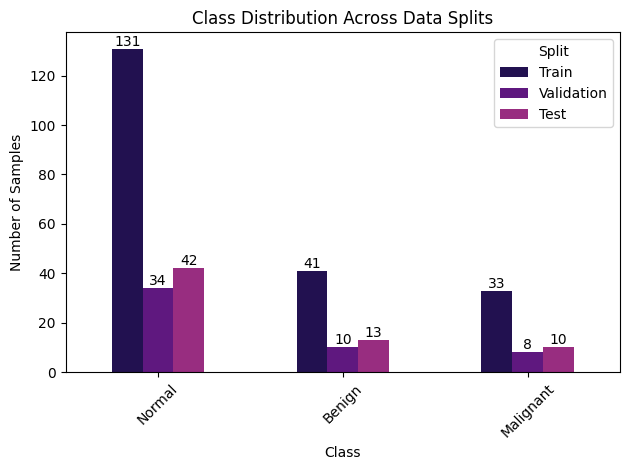


Training with RESNET18 model...
Using device: cpu

Starting training...
Epoch [1/10]
Train Loss: 1.1114, Train Acc: 34.63%
Val Loss: 0.9824, Val Acc: 65.38%
Epoch [2/10]
Train Loss: 0.9290, Train Acc: 62.44%
Val Loss: 0.8976, Val Acc: 65.38%
Epoch [3/10]
Train Loss: 0.9143, Train Acc: 63.90%
Val Loss: 0.8876, Val Acc: 65.38%
Epoch [4/10]
Train Loss: 0.8840, Train Acc: 63.90%
Val Loss: 0.8905, Val Acc: 65.38%
Epoch [5/10]
Train Loss: 0.8672, Train Acc: 64.39%
Val Loss: 0.8993, Val Acc: 65.38%
Epoch [6/10]
Train Loss: 0.8460, Train Acc: 63.90%
Val Loss: 0.9117, Val Acc: 65.38%
Epoch [7/10]
Train Loss: 0.8135, Train Acc: 63.90%
Val Loss: 0.9309, Val Acc: 65.38%
Epoch [8/10]
Train Loss: 0.8666, Train Acc: 64.88%
Val Loss: 0.9463, Val Acc: 65.38%
Epoch [9/10]
Train Loss: 0.8061, Train Acc: 65.37%
Val Loss: 0.9690, Val Acc: 65.38%
Epoch [10/10]
Train Loss: 0.8023, Train Acc: 66.34%
Val Loss: 1.0001, Val Acc: 65.38%

Evaluating model...


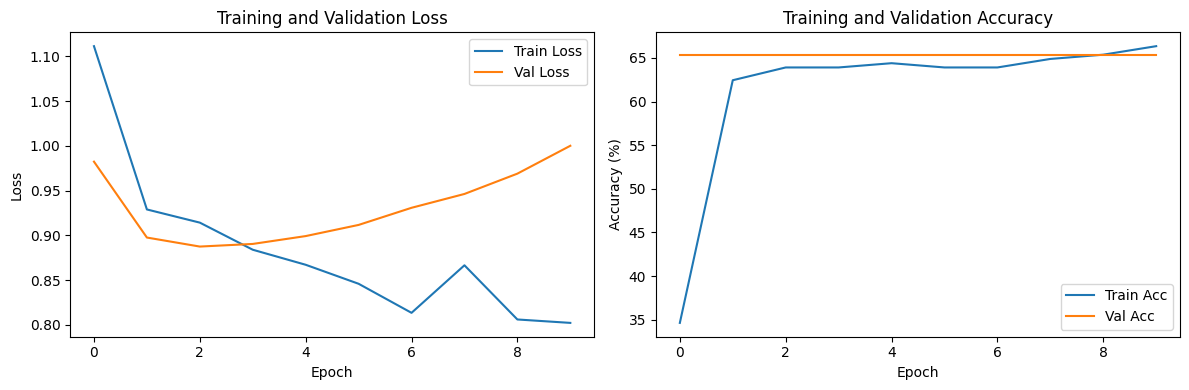


Classification Report:
              precision    recall  f1-score   support

      Normal       0.65      1.00      0.79        42
      Benign       0.00      0.00      0.00        13
   Malignant       0.00      0.00      0.00        10

    accuracy                           0.65        65
   macro avg       0.22      0.33      0.26        65
weighted avg       0.42      0.65      0.51        65


Confusion Matrix:


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


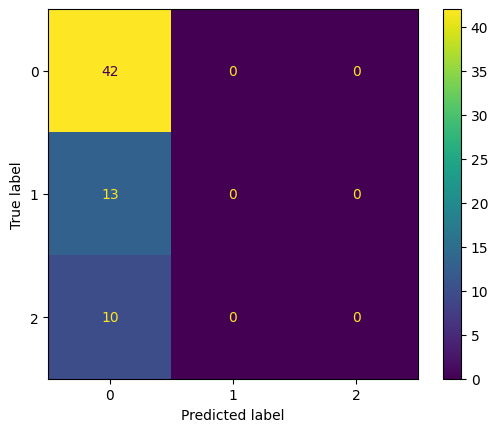

In [71]:
if __name__ == "__main__":
    models = ['resnet18']
    results = {}
    
    for model in models:
        print(f"\n{'='*50}")
        print(f"Training {model.upper()}")
        print(f"{'='*50}")
        
        trainer, history, data_module = main(
            model=model
        )
        
        results[model] = {
            'trainer': trainer,
            'history': history
        }

### RESNET-18 with Sampling & Data Augmentation


Training RESNET18

Preparing datasets...
Original distribution of Classes:
Severity_Abnormality
N    207
B     64
M     51
Name: count, dtype: int64

Class Distribution after mapping:
Normal       207
Benign        64
Malignant     51
Name: count, dtype: int64
Data setup completed:
Training samples: 257
Validation samples: 52
Test samples: 65


<Figure size 1200x600 with 0 Axes>

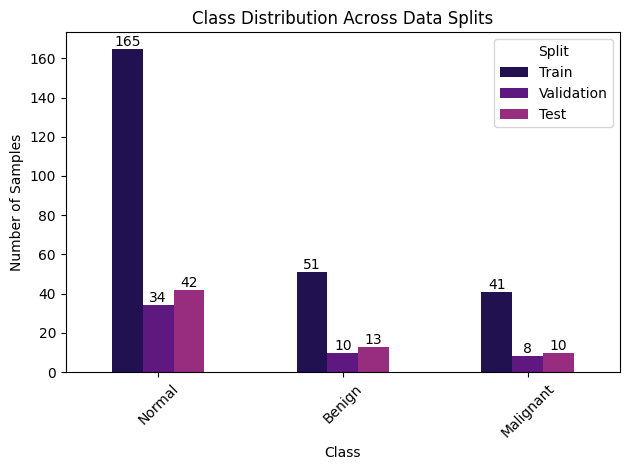


Training with RESNET18 model...
Using device: cpu

Starting training...
Epoch [1/10]
Train Loss: 1.1031, Train Acc: 30.74%
Val Loss: 1.1112, Val Acc: 21.15%
Epoch [2/10]
Train Loss: 1.1075, Train Acc: 34.63%
Val Loss: 1.1435, Val Acc: 19.23%
Epoch [3/10]
Train Loss: 1.0774, Train Acc: 34.24%
Val Loss: 1.1541, Val Acc: 15.38%
Epoch [4/10]
Train Loss: 1.1125, Train Acc: 32.68%
Val Loss: 1.1480, Val Acc: 15.38%
Epoch [5/10]
Train Loss: 1.0862, Train Acc: 40.08%
Val Loss: 1.1084, Val Acc: 28.85%
Epoch [6/10]
Train Loss: 1.0894, Train Acc: 45.14%
Val Loss: 1.1071, Val Acc: 32.69%
Epoch [7/10]
Train Loss: 1.0659, Train Acc: 48.25%
Val Loss: 1.0497, Val Acc: 42.31%
Epoch [8/10]
Train Loss: 1.0617, Train Acc: 50.19%
Val Loss: 1.0556, Val Acc: 34.62%
Epoch [9/10]
Train Loss: 1.0399, Train Acc: 47.47%
Val Loss: 1.0438, Val Acc: 42.31%
Epoch [10/10]
Train Loss: 1.0457, Train Acc: 43.19%
Val Loss: 0.9911, Val Acc: 51.92%

Evaluating model...


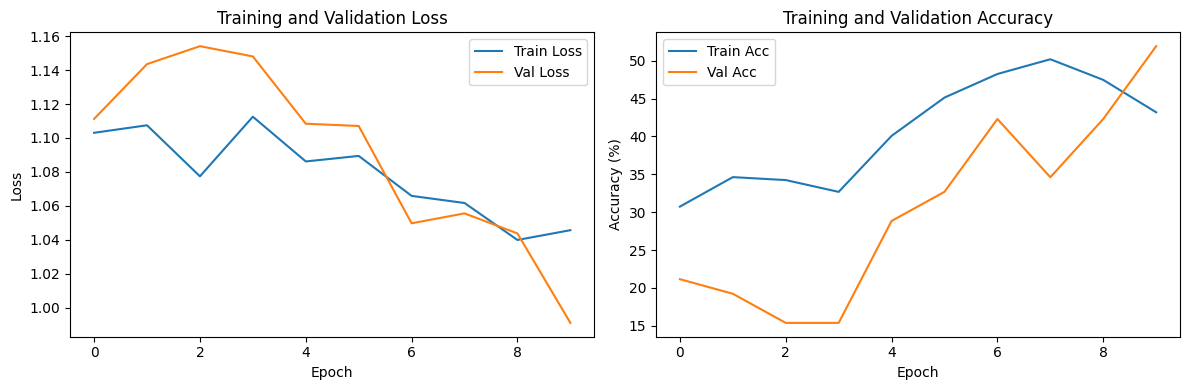


Classification Report:
              precision    recall  f1-score   support

      Normal       0.52      0.36      0.42        42
      Benign       0.12      0.15      0.14        13
   Malignant       0.10      0.20      0.13        10

    accuracy                           0.29        65
   macro avg       0.25      0.24      0.23        65
weighted avg       0.37      0.29      0.32        65


Confusion Matrix:


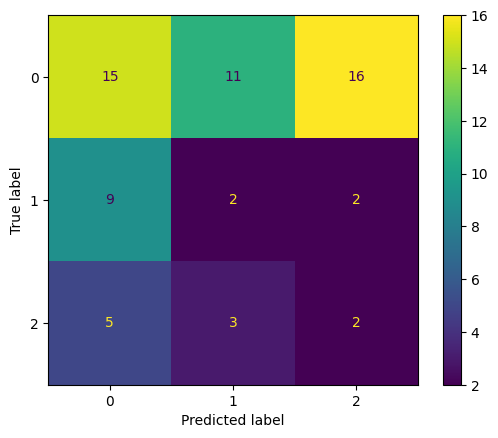

In [156]:
if __name__ == "__main__":
    models = ['resnet18']
    results = {}
    
    for model in models:
        print(f"\n{'='*50}")
        print(f"Training {model.upper()}")
        print(f"{'='*50}")
        
        trainer, history, data_module = main(
            model=model
        )
        
        results[model] = {
            'trainer': trainer,
            'history': history
        }


Training RESNET34

Preparing datasets...
Original distribution of Classes:
Severity_Abnormality
N    207
B     64
M     51
Name: count, dtype: int64

Class Distribution after mapping:
Normal       207
Benign        64
Malignant     51
Name: count, dtype: int64
Data setup completed:
Training samples: 257
Validation samples: 52
Test samples: 65


<Figure size 1200x600 with 0 Axes>

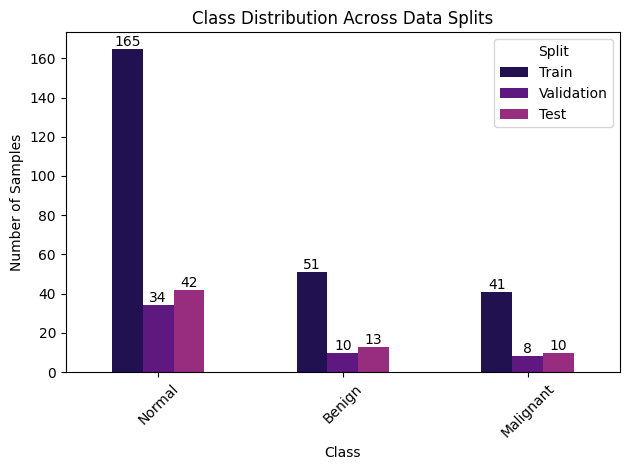


Training with RESNET34 model...
Using device: cpu


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 155MB/s]



Starting training...
Epoch [1/10]
Train Loss: 1.1531, Train Acc: 34.24%
Val Loss: 1.1244, Val Acc: 23.08%
Epoch [2/10]
Train Loss: 1.1412, Train Acc: 35.80%
Val Loss: 1.2243, Val Acc: 19.23%
Epoch [3/10]
Train Loss: 1.1248, Train Acc: 36.19%
Val Loss: 1.2982, Val Acc: 19.23%
Epoch [4/10]
Train Loss: 1.1287, Train Acc: 33.07%
Val Loss: 1.1616, Val Acc: 21.15%
Epoch [5/10]
Train Loss: 1.0702, Train Acc: 35.41%
Val Loss: 1.1331, Val Acc: 26.92%
Epoch [6/10]
Train Loss: 1.1947, Train Acc: 35.80%
Val Loss: 1.1525, Val Acc: 23.08%
Epoch [7/10]
Train Loss: 1.0921, Train Acc: 38.91%
Val Loss: 1.0695, Val Acc: 42.31%
Epoch [8/10]
Train Loss: 1.0451, Train Acc: 46.30%
Val Loss: 1.1570, Val Acc: 25.00%
Epoch [9/10]
Train Loss: 1.0817, Train Acc: 35.41%
Val Loss: 1.1596, Val Acc: 32.69%
Epoch [10/10]
Train Loss: 1.1050, Train Acc: 43.19%
Val Loss: 1.0725, Val Acc: 34.62%

Evaluating model...


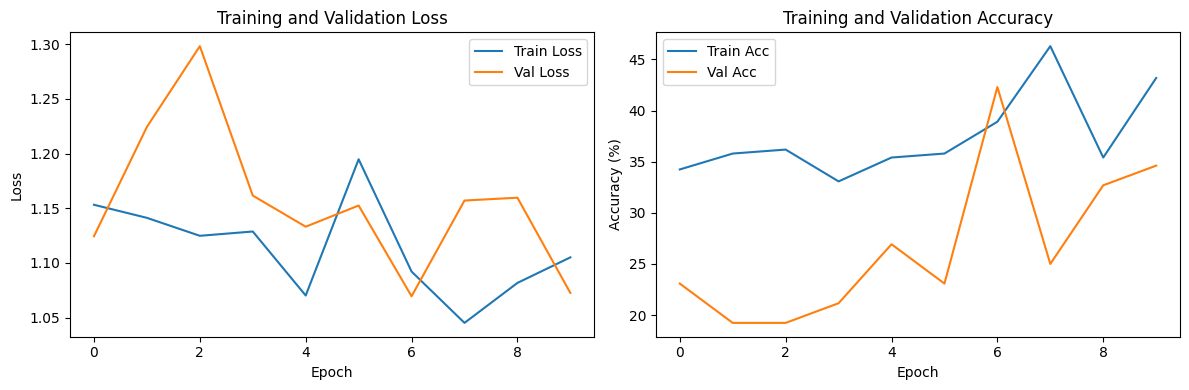


Cohen Kappa Score:
-0.03826955074875227

Classification Report:
              precision    recall  f1-score   support

      Normal       0.47      0.17      0.25        42
      Benign       0.20      0.46      0.28        13
   Malignant       0.20      0.40      0.27        10

    accuracy                           0.26        65
   macro avg       0.29      0.34      0.26        65
weighted avg       0.37      0.26      0.26        65


Confusion Matrix:


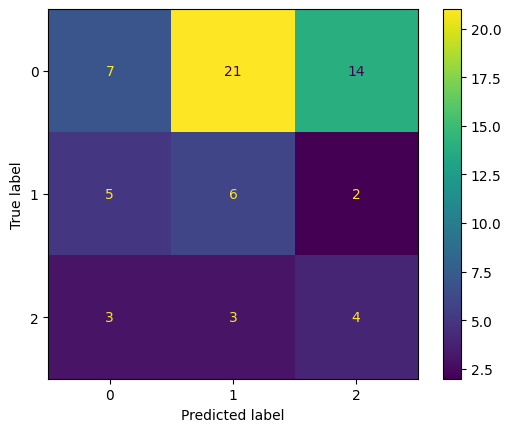

In [190]:
if __name__ == "__main__":
    models = ['resnet34']
    results = {}
    
    for model in models:
        print(f"\n{'='*50}")
        print(f"Training {model.upper()}")
        print(f"{'='*50}")
        
        trainer, history, data_module = main(
            model=model
        )
        
        results[model] = {
            'trainer': trainer,
            'history': history
        }

## Breast Tissue Density Classification

In [98]:
def tissue_density_prepare_data(scan_df):
    """
    Prepare data for three classes: Normal, Benign, and Malignant
    """
    print("Original distribution of Classes:")
    print(scan_df['Background_Tissue'].value_counts())
    
    # Convert labels to numeric: Normal=0, Benign=1, Malignant=2
    label_map = {'G': 0, 'D': 1, 'F': 2}
    labels = scan_df['Background_Tissue'].map(label_map).values
    image_paths = scan_df['scan_path'].values
    
    print("\nClass Distribution after mapping:")
    print(pd.Series(labels).map({0: 'G', 1: 'D',  2: 'F'}).value_counts())
    
    # Split data
    train_paths, test_paths, train_labels, test_labels = train_test_split(
        image_paths, labels, test_size=0.2, random_state=42, stratify=labels
    )
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        train_paths, train_labels, test_size=0.2, random_state=42, 
        stratify=train_labels
    )
    
    return (train_paths, val_paths, test_paths, 
            train_labels, val_labels, test_labels)

In [99]:
class TissueDensityPipeline:
    def __init__(self, 
                 scan_df,
                 preprocessor,
                 augmenter,
                 batch_size=32):
        """
        Args:
            scan_df: DataFrame containing image paths and labels
            preprocessor: Image preprocessing object
            augmenter: Data augmentation object (optional)
            batch_size: Batch size for DataLoader
        """
        self.scan_df = scan_df
        self.preprocessor = preprocessor
        self.augmenter = augmenter
        self.batch_size = batch_size
        
        # Initialize datasets
        self.train_dataset = None
        self.val_dataset = None
        self.test_dataset = None
        
        # Initialize data loaders
        self.train_loader = None
        self.val_loader = None
        self.test_loader = None
        
    def setup(self):
        """Prepare the data"""
        # Split the data
        (train_paths, val_paths, test_paths,
         train_labels, val_labels, test_labels) = tissue_density_prepare_data(self.scan_df)
        
        sample_weights = calculate_class_weights(train_labels)
        
        # Create datasets
        self.train_dataset = MIASDataset(
            train_paths, train_labels, 
            self.preprocessor, 
            self.augmenter
        )
        
        # Create weighted sampler
        self.train_sampler = WeightedRandomSampler(
            weights=sample_weights,
            num_samples=len(train_labels),
            replacement=True
        )
        
        self.val_dataset = MIASDataset(
            val_paths, val_labels, 
            self.preprocessor,
            augmenter=None
        )
        
        self.test_dataset = MIASDataset(
            test_paths, test_labels, 
            self.preprocessor,
            augmenter=None
        )
        
        # Create data loaders
        self.train_loader = DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            sampler = self.train_sampler
        )
        
        self.val_loader = DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False
        )
        
        self.test_loader = DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False
        )
        
        print(f"Data setup completed:")
        print(f"Training samples: {len(self.train_dataset)}")
        print(f"Validation samples: {len(self.val_dataset)}")
        print(f"Test samples: {len(self.test_dataset)}")
        
        # Visualize data distribution
        self.plot_data_distribution()
        
    def get_loaders(self):
        """Return all data loaders"""
        return self.train_loader, self.val_loader, self.test_loader
    
    def plot_data_distribution(self):
        """Plot the distribution of classes in each split"""
        # Get labels for each split
        train_labels = [label.item() for _, label in self.train_dataset]
        val_labels = [label.item() for _, label in self.val_dataset]
        test_labels = [label.item() for _, label in self.test_dataset]
        
        # Create distribution dictionary
        distribution = {
        'Train': pd.Series(train_labels).map({0: 'G', 1: 'D',  2: 'F'}).value_counts(),
        'Validation': pd.Series(val_labels).map({0: 'G', 1: 'D',  2: 'F'}).value_counts(),
        'Test': pd.Series(test_labels).map({0: 'G', 1: 'D',  2: 'F'}).value_counts()
        }
    
        # Plot
        plt.figure(figsize=(12, 6))
        df_dist = pd.DataFrame(distribution)
        
        ax = df_dist.plot(kind='bar', color=sns.color_palette("magma"))
        plt.title('Class Distribution Across Data Splits')
        plt.xlabel('Class')
        plt.ylabel('Number of Samples')
        plt.legend(title='Split')
        plt.xticks(rotation=45)
        
        # Add value labels on bars
        for container in ax.containers:
            ax.bar_label(container)
            
        plt.tight_layout()
        plt.show()

In [100]:
def main(model):
    """
    Main function that runs the complete mammogram classification pipeline
    
    Args:
        model (str): Type of model to use ('resnet18' or 'cnn')
    """
    # Configuration
    config = {
        # Model parameters
        'model': model,
        'num_classes': 3,
        'class_names': ['G', 'D',  'F'],
        'training_params': {
            'num_epochs': 10,
            'batch_size': 32,
            'learning_rate': 0.0001,
            'optimizer': 'adam',
            'criterion': 'cross_entropy',
        },
        'preprocessing_params': {
            'target_size': (224, 224),
            'gaussian_kernel': (5, 5),
            'clahe_clip': 2.0,
            'clahe_grid': (8, 8),
            'batch_size': 32,
            'use_augmentation': True
        }
    }

    # Initialize components
    preprocessing_config = config['preprocessing_params']
    preprocessor = ScanPreprocessor(
        target_size=preprocessing_config['target_size'],
        gaussian_kernel=preprocessing_config['gaussian_kernel'],
        clahe_clip=preprocessing_config['clahe_clip'],
        clahe_grid=preprocessing_config['clahe_grid']
    )
    
    augmenter = DataAugmentation() if preprocessing_config['use_augmentation'] else None
    
    # Setup data module
    print("\nPreparing datasets...")
    data_module = TissueDensityPipeline(
        scan_df=scan_df,
        preprocessor=preprocessor,
        augmenter=augmenter,
        batch_size=config['training_params']['batch_size'],
    )
    data_module.setup()
    
    train_loader, val_loader, test_loader = data_module.get_loaders()
    
    # Initialize and train model
    print(f"\nTraining with {model.upper()} model...")
    trainer = ModelTrainer(config=config)
    
    print("\nStarting training...")
    history = trainer.train(
        train_loader=train_loader,
        val_loader=val_loader
    )
    
    # Evaluate results
    print("\nEvaluating model...")
    trainer.plot_results(history)
    trainer.evaluate(test_loader)
    
    return trainer, history, data_module


Training RESNET34

Preparing datasets...
Original distribution of Classes:
Background_Tissue
D    112
F    106
G    104
Name: count, dtype: int64

Class Distribution after mapping:
D    112
F    106
G    104
Name: count, dtype: int64
Data setup completed:
Training samples: 205
Validation samples: 52
Test samples: 65


<Figure size 1200x600 with 0 Axes>

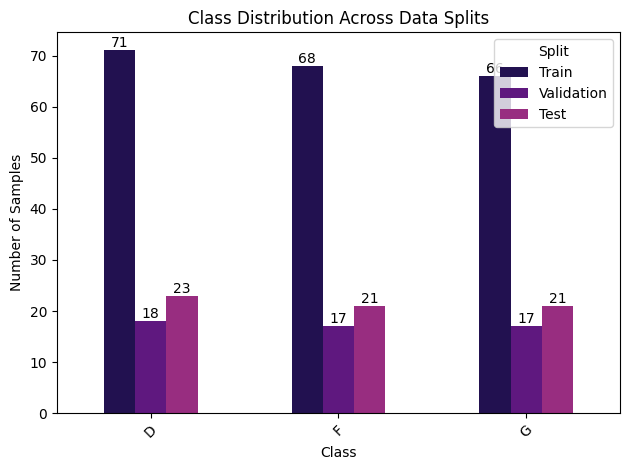


Training with RESNET34 model...
Using device: cuda

Starting training...
Epoch [1/10]
Train Loss: 1.0893, Train Acc: 42.44%
Val Loss: 1.0910, Val Acc: 32.69%
Epoch [2/10]
Train Loss: 0.9629, Train Acc: 55.12%
Val Loss: 1.0921, Val Acc: 34.62%
Epoch [3/10]
Train Loss: 0.9378, Train Acc: 60.49%
Val Loss: 1.1085, Val Acc: 42.31%
Epoch [4/10]
Train Loss: 0.8258, Train Acc: 65.37%
Val Loss: 1.1601, Val Acc: 38.46%
Epoch [5/10]
Train Loss: 0.7675, Train Acc: 68.78%
Val Loss: 1.1311, Val Acc: 38.46%
Epoch [6/10]
Train Loss: 0.7118, Train Acc: 70.73%
Val Loss: 1.0736, Val Acc: 40.38%
Epoch [7/10]
Train Loss: 0.6247, Train Acc: 78.54%
Val Loss: 1.1704, Val Acc: 32.69%
Epoch [8/10]
Train Loss: 0.5975, Train Acc: 76.59%
Val Loss: 1.2129, Val Acc: 32.69%
Epoch [9/10]
Train Loss: 0.5527, Train Acc: 79.51%
Val Loss: 1.5422, Val Acc: 32.69%
Epoch [10/10]
Train Loss: 0.5530, Train Acc: 78.54%
Val Loss: 0.8827, Val Acc: 63.46%

Evaluating model...


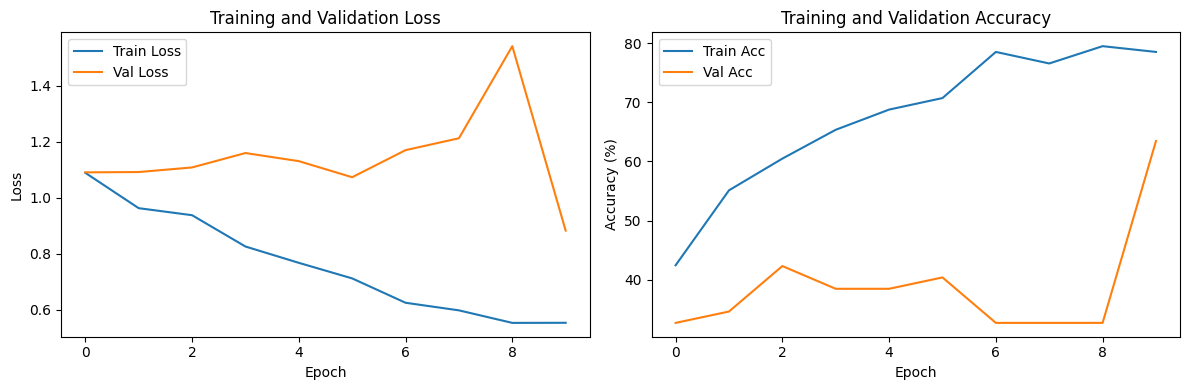


Cohen Kappa Score:
0.38247712878254747

Classification Report:
              precision    recall  f1-score   support

           G       0.50      0.48      0.49        21
           D       0.78      0.30      0.44        23
           F       0.58      1.00      0.74        21

    accuracy                           0.58        65
   macro avg       0.62      0.59      0.55        65
weighted avg       0.63      0.58      0.55        65


Confusion Matrix:


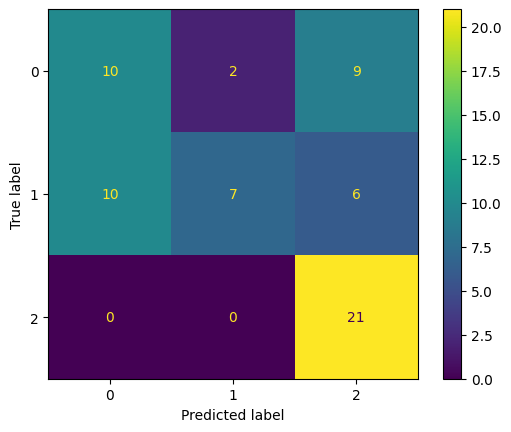

In [101]:
if __name__ == "__main__":
    models = ['resnet34']
    results = {}
    
    for model in models:
        print(f"\n{'='*50}")
        print(f"Training {model.upper()}")
        print(f"{'='*50}")
        
        trainer, history, data_module = main(
            model=model
        )
        
        results[model] = {
            'trainer': trainer,
            'history': history
        }